In [1]:
using Rocket, ReactiveMP, GraphPPL, Distributions
using BenchmarkTools, Random, Plots

In [2]:
@model function smoothing(n, x0, c::ConstVariable, P::ConstVariable)
    
    x_prior ~ NormalMeanVariance(mean(x0), cov(x0)) 

    x = randomvar(n)
    y = datavar(Float64, n)
    
    x_prev = x_prior
    
    for i in 1:n
        x[i] ~ x_prev + c
        y[i] ~ NormalMeanVariance(x[i], P)
        
        x_prev = x[i]
    end

    return x, y
end

smoothing (generic function with 1 method)

In [3]:
seed = 123

rng = MersenneTwister(seed)

P = 100.0

# For large `n` apply: smoothing(..., options = (limit_stack_depth = 500, ))
n = 500

hidden = collect(1:n)
data   = hidden + rand(rng, Normal(0.0, sqrt(P)), n);

In [4]:
function inference(data, x0, P)
    n = length(data)
    
    _, (x, y) = smoothing(n, x0, 1.0, P);

    x_buffer  = buffer(Marginal, n)
    marginals = getmarginals(x)
    
    subscription = subscribe!(marginals, x_buffer)
    
    update!(y, data)
    
    unsubscribe!(subscription)
    
    return getvalues(x_buffer)
end

inference (generic function with 1 method)

In [5]:
x0_prior = NormalMeanVariance(0.0, 10000.0)

NormalMeanVariance{Float64}(μ=0.0, v=10000.0)

In [6]:
@benchmark res = inference($data, $x0_prior, $P)

BenchmarkTools.Trial: 252 samples with 1 evaluation.
 Range (min … max):  16.582 ms … 32.011 ms  ┊ GC (min … max): 0.00% … 40.80%
 Time  (median):     18.004 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   19.870 ms ±  4.273 ms  ┊ GC (mean ± σ):  9.31% ± 13.49%

  ▁█▃▂▃ ▂                                                      
  █████████▇▄▃▄▄▃▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▃▃▄▄▅▃▁▃▃▃▃▂▂▃▁▃▂ ▃
  16.6 ms         Histogram: frequency by time        30.8 ms <

 Memory estimate: 12.55 MiB, allocs estimate: 209091.

In [7]:
@benchmark res = inference($data, $x0_prior, $P)

BenchmarkTools.Trial: 249 samples with 1 evaluation.
 Range (min … max):  16.687 ms … 34.911 ms  ┊ GC (min … max): 0.00% … 39.67%
 Time  (median):     18.168 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   20.063 ms ±  4.415 ms  ┊ GC (mean ± σ):  9.46% ± 13.77%

   ▆▆█▂▄▆▁                                                     
  ▆███████▅▄▃▆▃▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▄▇▄▂▃▃▁▂▁▁▂▃▃▃▂ ▃
  16.7 ms         Histogram: frequency by time        31.7 ms <

 Memory estimate: 12.55 MiB, allocs estimate: 209091.

In [8]:
results = inference(data, x0_prior, P);

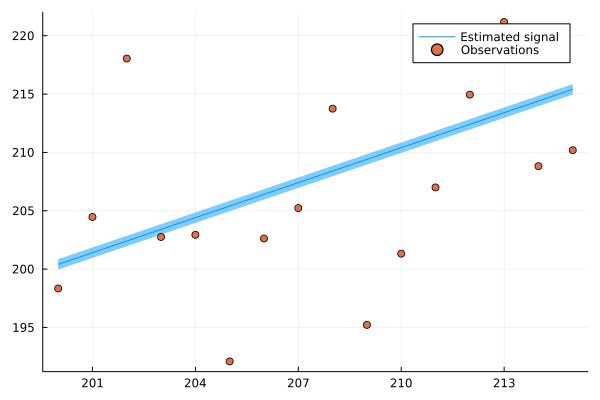

In [9]:
let 
    subrange = 200:215
    
    m = mean.(results)[subrange]
    s = std.(results)[subrange]
    
    p = plot()
    
    p = plot!(subrange, m, ribbon = s, label = "Estimated signal")
    p = scatter!(subrange, data[subrange], label = "Observations")
    
    plot(p)
end